===================================================
## 1. MLP-next
#### a multi-layer perceptron (f) trained to predict the next time level $\alpha_{n+1} = f(\alpha_n)$

#### Tianyi Zhao
===================================================

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`)

<IPython.core.display.Javascript object>

In [2]:
notebookName 

'1.POD-MLP-final-Copy1.ipynb'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tf.random.set_seed(42)
seed(42)

## Load data

In [5]:
data_dir = './../data/single_domain/'
pod_coeffs = np.load(data_dir + 'pod_coeffs_1.npy') 
pod_coeffs.shape

(1, 10, 1999)

In [6]:
npod = 5
X_pod = np.transpose(pod_coeffs.reshape(10, 1999)[:npod])
step = 0.25
times = np.arange(0, len(X_pod)*step, step, dtype="float64")

X_pod.shape

(1999, 5)

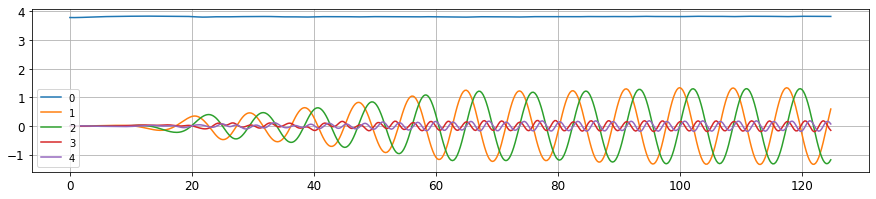

In [7]:
fig, ax = plt.subplots(1,1, figsize=[15,3])
ax.plot(times[0:500], X_pod[0:500]);
ax.grid()
ax.legend(range(5),loc='lower left')

## Prepare data

In [8]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Reconstruct the time series into a supervised learning dataset.
    input:
    data, list or array, sequence of observations
    n_in, int, length of lagging observations (X)
    n_out, int, length of observations (y)
    dropnan, boolean, discard rows with NaN values
    return:
    Pandas DataFrame, reconstructed dataset
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input series (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # predict series (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat column name with data
    agg = concat(cols, axis=1)
    agg.columns = names
    # discard rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# create dataset
dataset = DataFrame()
for i in range(5):
    dataset['ob%d'%i] = X_pod[:,i]
values = dataset.values
# make sure all values are float
values = values.astype('float32')
# Structured as a supervised learning problem
reframed = series_to_supervised(values, 1, 1)
# Normalized
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed.values)
values = scaled

In [10]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,3.788370,0.005678,-0.000566,-0.008302,0.009564,3.786842,0.005688,-0.000849,-0.008457,0.009378
2,3.786842,0.005688,-0.000849,-0.008457,0.009378,3.786378,0.005678,-0.001172,-0.008663,0.009124
3,3.786378,0.005678,-0.001172,-0.008663,0.009124,3.786565,0.005711,-0.001509,-0.008947,0.008888
4,3.786565,0.005711,-0.001509,-0.008947,0.008888,3.787221,0.005720,-0.001844,-0.009363,0.008676
5,3.787221,0.005720,-0.001844,-0.009363,0.008676,3.788207,0.005675,-0.002248,-0.009771,0.008444


In [11]:
# split train, validation and test set by 8:1:1
n_train = 1600
train = values[:n_train, :]
validation = values[n_train:n_train+200, :]
test = values[n_train+200:, :]
# create input and output
X_train, y_train = train[:, :5], train[:, 5:]
X_val, y_val = validation[:, :5], validation[:, 5:]
X_test, y_test = test[:, :5], test[:, 5:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1600, 5) (1600, 5) (200, 5) (200, 5) (198, 5) (198, 5)


## Train with MLP

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                       train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

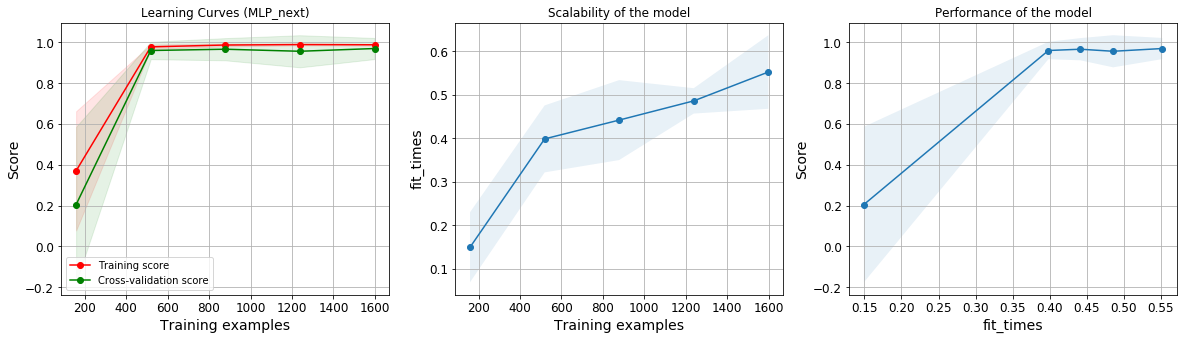

In [13]:
#fig, axes = plt.subplots(1, 3, figsize=(10, 15))

X, y = values[:, :5], values[:, 5:]

title = "Learning Curves (MLP_next)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPRegressor()
#estimator = model()
plot_learning_curve(estimator, title, X, y, axes=None, ylim=None,
                    cv=None, n_jobs=4)

plt.show()

In [14]:
epochs = 200
batch_size = 16
lr = 1e-3

# input_dim, input_length = input_shape(input_length, input_dim)
n_input = X_train.shape[1]
n_output = y_train.shape[1]

In [15]:
def make_mlp_model():
    model = tf.keras.Sequential()
    #model.add(Flatten(input_shape=X_train.shape))
    model.add(keras.layers.Dense(units=100, activation="relu", input_dim=n_input))    #units of hidden layer is 100
    model.add(keras.layers.Dense(units=100, activation="relu"))
    model.add(keras.layers.Dense(units=n_output))    #output layer, dim=n_output
    
    return model

In [16]:
mlp = make_mlp_model()
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 11,205
Trainable params: 11,205
Non-trainable params: 0
_________________________________________________________________


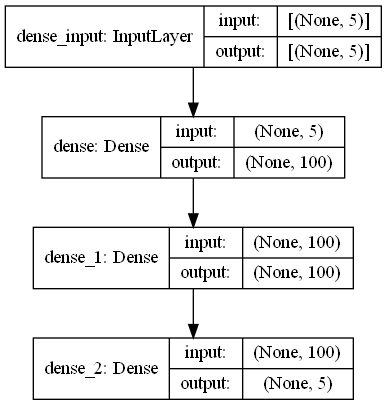

In [17]:
#mlp.built((None, 5))
keras.utils.plot_model(mlp,to_file='POD-MLP.png',show_shapes=True)

In [18]:
def plot_acc_loss(history):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4])
    ax[0].grid()
    ax[0].plot(history['accuracy'],label='training acc')
    ax[0].plot(history['val_accuracy'],label='val acc')
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(loc='lower right')
    
    ax[1].grid()
    ax[1].plot(history['loss'],label='training loss')
    ax[1].plot(history['val_loss'], label='val loss')
    ax[1].set_title('model loss')
    ax[1].set_yscale('log')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(loc='lower right')

In [19]:
# fit model
optimizer = keras.optimizers.Adam(lr)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=lr*0.01)
mlp.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
start = time.process_time()
mlp.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_val, y_val), shuffle=False,
        initial_epoch=0)
elapsed = (time.process_time() - start)

Train on 1600 samples, validate on 200 samples
Epoch 1/200
1600/1600 [==============================] - 1s 511us/sample - loss: 0.0389 - accuracy: 0.5063 - val_loss: 5.0289e-04 - val_accuracy: 0.9300
Epoch 2/200
1600/1600 [==============================] - 0s 85us/sample - loss: 0.0012 - accuracy: 0.9312 - val_loss: 7.5401e-05 - val_accuracy: 0.9850
Epoch 3/200
1600/1600 [==============================] - 0s 84us/sample - loss: 8.6880e-04 - accuracy: 0.9406 - val_loss: 3.2246e-05 - val_accuracy: 0.9900
Epoch 4/200
1600/1600 [==============================] - 0s 90us/sample - loss: 6.9721e-04 - accuracy: 0.9481 - val_loss: 2.1229e-05 - val_accuracy: 0.9950
Epoch 5/200
1600/1600 [==============================] - 0s 85us/sample - loss: 5.7795e-04 - accuracy: 0.9569 - val_loss: 1.6720e-05 - val_accuracy: 0.9950
Epoch 6/200
1600/1600 [==============================] - 0s 89us/sample - loss: 4.9301e-04 - accuracy: 0.9644 - val_loss: 1.4974e-05 - val_accuracy: 0.9950
Epoch 7/200
1600/1600 [=

Epoch 53/200
1600/1600 [==============================] - 0s 92us/sample - loss: 1.4867e-04 - accuracy: 0.9794 - val_loss: 3.3557e-06 - val_accuracy: 1.0000
Epoch 54/200
1600/1600 [==============================] - 0s 97us/sample - loss: 1.5109e-04 - accuracy: 0.9781 - val_loss: 3.1827e-06 - val_accuracy: 1.0000
Epoch 55/200
1600/1600 [==============================] - 0s 86us/sample - loss: 1.5619e-04 - accuracy: 0.9744 - val_loss: 3.3473e-06 - val_accuracy: 1.0000
Epoch 56/200
1600/1600 [==============================] - 0s 84us/sample - loss: 1.5197e-04 - accuracy: 0.9800 - val_loss: 3.3754e-06 - val_accuracy: 1.0000
Epoch 57/200
1600/1600 [==============================] - 0s 86us/sample - loss: 1.4649e-04 - accuracy: 0.9756 - val_loss: 3.3185e-06 - val_accuracy: 1.0000
Epoch 58/200
1600/1600 [==============================] - 0s 86us/sample - loss: 1.5777e-04 - accuracy: 0.9806 - val_loss: 3.3761e-06 - val_accuracy: 1.0000
Epoch 59/200
1600/1600 [==============================] - 

1600/1600 [==============================] - 0s 86us/sample - loss: 1.0827e-04 - accuracy: 0.9800 - val_loss: 3.3280e-06 - val_accuracy: 1.0000
Epoch 106/200
1600/1600 [==============================] - 0s 85us/sample - loss: 1.1792e-04 - accuracy: 0.9800 - val_loss: 3.4572e-06 - val_accuracy: 1.0000
Epoch 107/200
1600/1600 [==============================] - 0s 86us/sample - loss: 1.0585e-04 - accuracy: 0.9800 - val_loss: 3.2043e-06 - val_accuracy: 1.0000
Epoch 108/200
1600/1600 [==============================] - 0s 86us/sample - loss: 1.0328e-04 - accuracy: 0.9800 - val_loss: 3.1683e-06 - val_accuracy: 1.0000
Epoch 109/200
1600/1600 [==============================] - 0s 85us/sample - loss: 1.1498e-04 - accuracy: 0.9787 - val_loss: 3.3174e-06 - val_accuracy: 1.0000
Epoch 110/200
1600/1600 [==============================] - 0s 84us/sample - loss: 1.0647e-04 - accuracy: 0.9781 - val_loss: 3.1307e-06 - val_accuracy: 1.0000
Epoch 111/200
1600/1600 [==============================] - 0s 92us

1600/1600 [==============================] - 0s 101us/sample - loss: 1.0015e-04 - accuracy: 0.9831 - val_loss: 2.6351e-06 - val_accuracy: 1.0000
Epoch 157/200
1600/1600 [==============================] - 0s 101us/sample - loss: 1.0572e-04 - accuracy: 0.9831 - val_loss: 2.7572e-06 - val_accuracy: 1.0000
Epoch 158/200
1600/1600 [==============================] - 0s 92us/sample - loss: 9.8762e-05 - accuracy: 0.9825 - val_loss: 2.6361e-06 - val_accuracy: 1.0000
Epoch 159/200
1600/1600 [==============================] - 0s 91us/sample - loss: 1.0652e-04 - accuracy: 0.9837 - val_loss: 2.6535e-06 - val_accuracy: 1.0000
Epoch 160/200
1600/1600 [==============================] - 0s 94us/sample - loss: 1.0983e-04 - accuracy: 0.9812 - val_loss: 2.6508e-06 - val_accuracy: 1.0000
Epoch 161/200
1600/1600 [==============================] - 0s 93us/sample - loss: 1.0543e-04 - accuracy: 0.9825 - val_loss: 2.5912e-06 - val_accuracy: 1.0000
Epoch 162/200
1600/1600 [==============================] - 0s 99

In [21]:
print("Training time:",elapsed)

Training time: 50.875


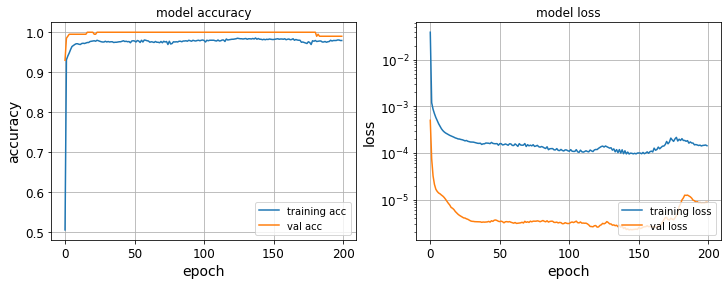

In [22]:
plot_acc_loss(mlp.history.history)

In [23]:
import joblib
joblib.dump(scaler, "models/scaler-mpl-next.pkl")
mlp.save("models/mlp-next.h5")

## Predict one next time level on test set

In [24]:
# make prediction
yhat = mlp.predict(X_test)
# Inverse scaling predicted value
yhat_inv = np.concatenate((X_test, yhat), axis=1)
yhat_inv = scaler.inverse_transform(yhat_inv)
yhat_inv = yhat_inv[:, 5:]
# Inverse scaling true value
y_inv = scaler.inverse_transform(test)
y_inv = y_inv[:, 5:]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_inv, yhat_inv))
print('Test RMSE of next time level: %.3f' % rmse)

Test RMSE of next time level: 0.003


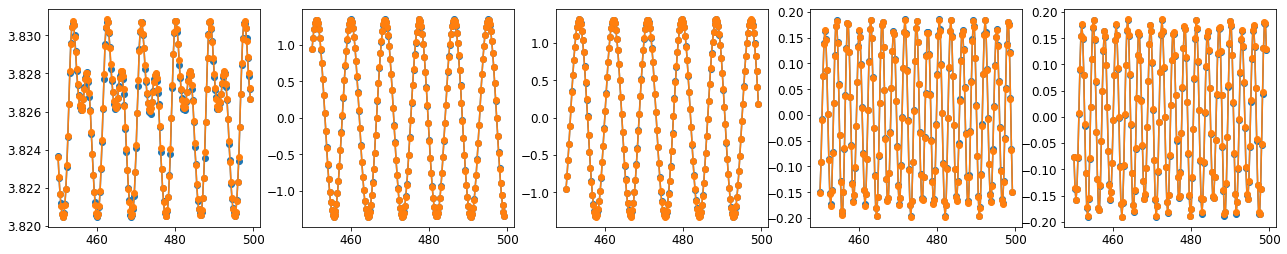

In [25]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(times[1800:-1], yhat_inv[:,i],'-o')
    ax.flatten()[i].plot(times[1800:-1], y_inv[:,i], '-o')

## Predict multiple time levels

In [26]:
def predict_next_time_level(x_test, x_inv, nstep, npredict):
    y_predall = []
    for i in range(npredict):
        yhat = mlp.predict(x_test)
        yhat_inv = np.concatenate((x_test, yhat), axis=1)
        yhat_inv = scaler.inverse_transform(yhat_inv)
        yhat_inv = yhat_inv[:, 5:]
        y_predall.append(yhat_inv[-1])
        #y_pred = step * yhat_inv + x_inv

        y_next = np.concatenate((yhat_inv, x_inv), axis=1)
        y_next = scaler.transform(y_next)
        y_next = y_next[:, :5]
        x_test = np.concatenate((x_test, [y_next[-1]]), axis=0)[-nstep:,:]
        x_inv = np.concatenate((x_inv, [yhat_inv[-1]]), axis=0)[-nstep:,:]
        
    return np.array(y_predall)

### Start point = time step 500

In [27]:
n = 500
nstep_init = 5
npredict = 100    # term = 35
time_level_pred = predict_next_time_level(values[n-nstep_init:n, :5], reframed.values[n-nstep_init:n, :5], nstep_init, npredict)
times_pred = np.arange(0, (len(X_pod)+npredict)*step, step, dtype="float64")

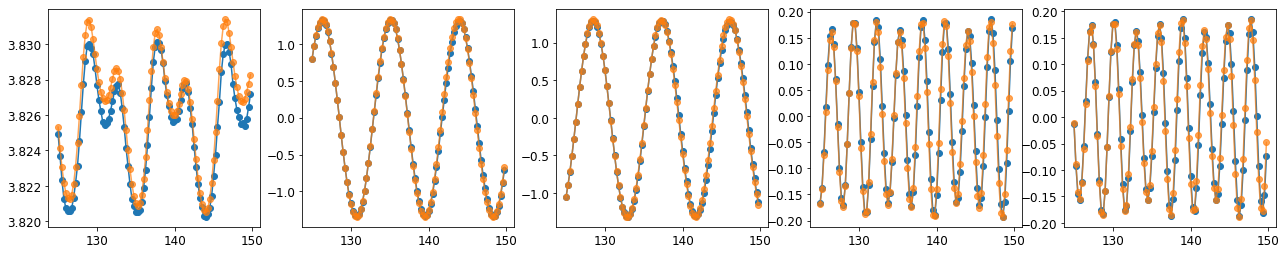

In [28]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(times_pred[n:n+npredict], time_level_pred[:,i],'-o')
    ax.flatten()[i].plot(times[n:n+npredict], reframed.values[n:n+npredict, i], '-o', alpha=0.7)

### Start point = time step 1000

In [29]:
n = 1000
nstep_init = 5
npredict = 100    # term = 35
time_level_pred = predict_next_time_level(values[n-nstep_init:n, :5], reframed.values[n-nstep_init:n, :5], nstep_init, npredict)
times_pred = np.arange(0, (len(X_pod)+npredict)*step, step, dtype="float64")

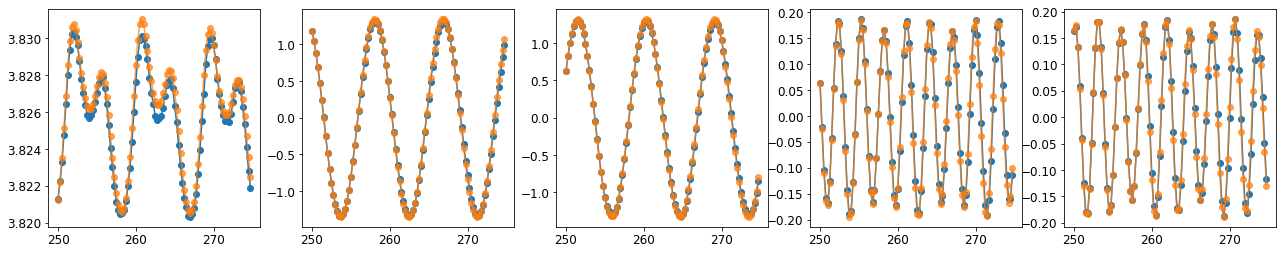

In [30]:
fig, ax = plt.subplots(1, 5, figsize=[22, 4])
for i in range(5):
    ax.flatten()[i].plot(times_pred[n:n+npredict], time_level_pred[:,i],'-o')
    ax.flatten()[i].plot(times[n:n+npredict], reframed.values[n:n+npredict, i], '-o', alpha=0.7)

## Predict the whole simulation

### Start point = time step 100

In [42]:
n = 100
nstep_init = 19
npredict = 1000    # term = 35
start = time.process_time()
time_level_pred = predict_next_time_level(values[n:nstep_init+n, :5], reframed.values[n:nstep_init+n, :5], nstep_init, npredict)
times_pred = np.arange(0, (len(X_pod)+npredict)*step, step, dtype="float64")
elapsed = (time.process_time() - start)
print("Predicting time:",elapsed)
x_pred = np.concatenate((reframed.values[n:nstep_init+n, :5], time_level_pred), axis=0)

Predicting time: 45.0625


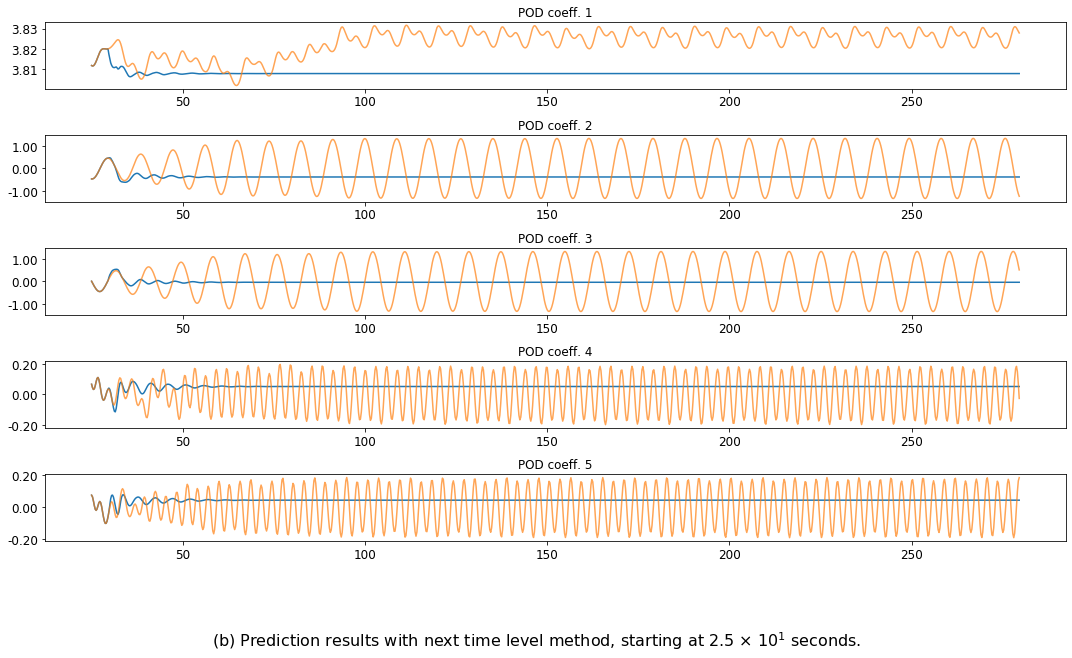

In [43]:
fig, ax = plt.subplots(5, 1, figsize=[15, 8])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times_pred[n:n+nstep_init+npredict], x_pred[:,i])
    ax.flatten()[i].plot(times[n:n+nstep_init+npredict], reframed.values[n:n+nstep_init+npredict, i], alpha=0.7)
plt.tight_layout()
my_suptitle = plt.suptitle("(b) Prediction results with next time level method, starting at 2.5 × $10^1$ seconds.", y=-0.1, fontsize=16)
plt.savefig('MLP_next_100.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

### Start point = time step 1000

In [45]:
n = 1000
nstep_init = 19
npredict = 1000    # term = 35
start = time.process_time()
time_level_pred = predict_next_time_level(values[n:nstep_init+n, :5], reframed.values[n:nstep_init+n, :5], nstep_init, npredict)
times_pred = np.arange(0, (len(X_pod)+npredict)*step, step, dtype="float64")
elapsed = (time.process_time() - start)
print("Predicting time:",elapsed)
x_pred = np.concatenate((reframed.values[n:nstep_init+n, :5], time_level_pred), axis=0)

Predicting time: 50.953125


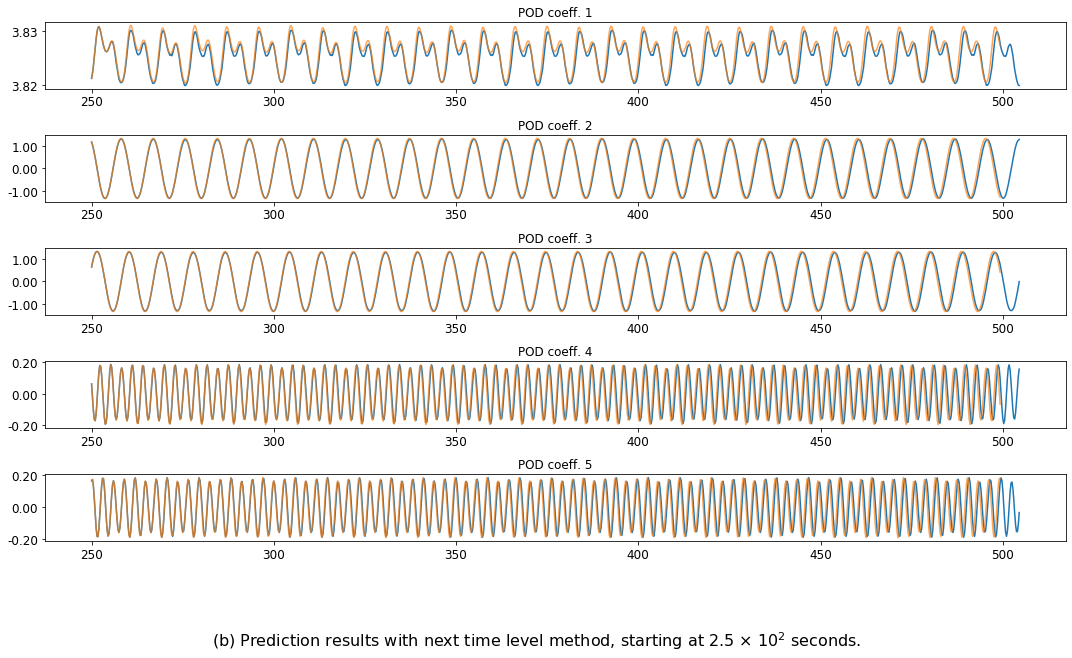

In [41]:
fig, ax = plt.subplots(5, 1, figsize=[15, 8])
for i in range(5):
    ax.flatten()[i].set_title("POD coeff. %d"%(i+1))
    ax.flatten()[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.flatten()[i].plot(times_pred[n:n+nstep_init+npredict], x_pred[:,i])
    ax.flatten()[i].plot(times[n:-1], reframed.values[n:, i], alpha=0.7)
plt.tight_layout()
my_suptitle = plt.suptitle("(b) Prediction results with next time level method, starting at 2.5 × $10^2$ seconds.", y=-0.1, fontsize=16)
plt.savefig('MLP_next_1000.png', dpi=300, bbox_inches='tight',bbox_extra_artists=[my_suptitle]) 

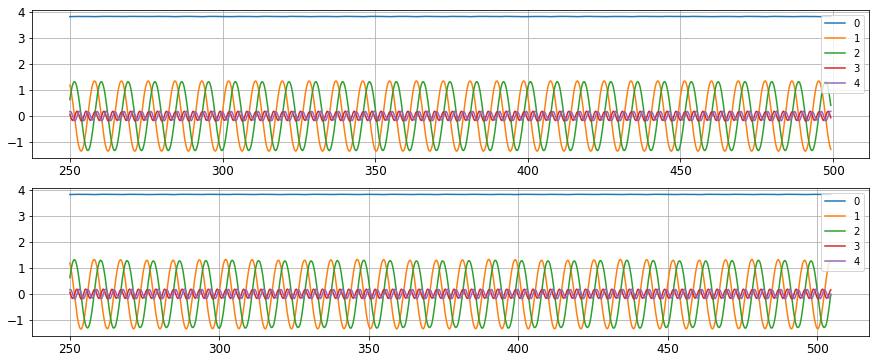

In [35]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(times[n:-1], reframed.values[n:, :5]);
ax[0].grid()
ax[0].legend(range(5))

ax[1].plot(times_pred[n:n+nstep_init+npredict], x_pred);
ax[1].grid()
ax[1].legend(range(5))

Output as `csv`

In [49]:
out_dir = 'outputs/'
pod_coeffs_gen = np.transpose(x_pred)
np.savetxt(out_dir+'mlp_next_1000.csv', pod_coeffs_gen , delimiter=',')

# generate reconstructed pod coeffs
pod_basis = np.load(data_dir+'pod_basis_1.npy')
reconstructed = np.reshape((pod_basis[:,:5] @ pod_coeffs_gen), [1, 2, 221, 42, -1])

np.save(out_dir+'mlp_next_1000.npy', reconstructed)

Calculate error and relative error

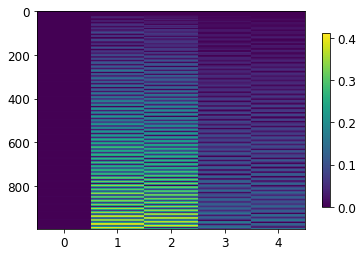

In [37]:
X_true = reframed.values[n:, :5]
X_pred = x_pred[:998]
error = X_pred-X_true
relative_error = error/X_true
plt.imshow(abs(error), aspect='auto', interpolation='None')
plt.colorbar(shrink=0.8)

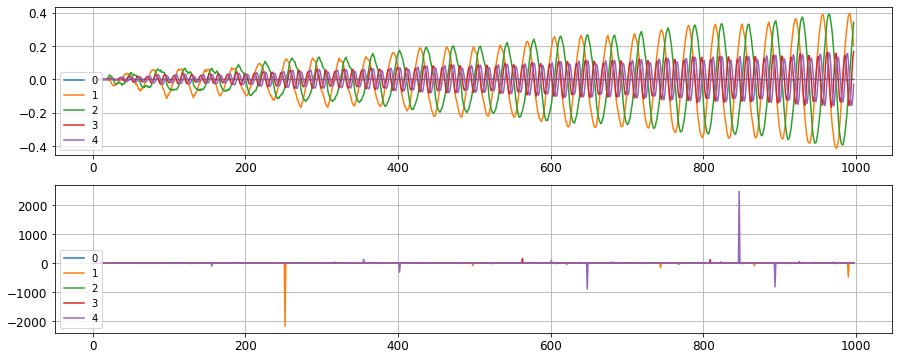

In [38]:
fig, ax = plt.subplots(2,1, figsize=[15,6])
ax[0].plot(error);
ax[0].grid()
ax[0].legend(range(5),loc='lower left')

ax[1].plot(relative_error);
ax[1].grid()
ax[1].legend(range(5),loc='lower left')

Calculate prediction RMSE

In [39]:
# calculate RMSE
pred_mse = np.mean(tf.keras.losses.MSE(X_true, X_pred))
pred_rmse = np.sqrt(pred_mse)
#config.prediction_rmse = pred_rmse
print('Prediction RMSE: %.4f' % pred_rmse)

Prediction RMSE: 0.1115


## Predict beyond simulation

### Start point = time step 1800

In [39]:
n = 1800
nstep_init = 5
npredict = 1000    # term = 35
start = time.process_time()
time_level_pred = predict_next_time_level(values[n-nstep_init:n, :5], reframed.values[n-nstep_init:n, :5], nstep_init, npredict)
times_pred = np.arange(0, (len(X_pod)+npredict)*step, step, dtype="float64")
elapsed = (time.process_time() - start)
print("Predicting time:",elapsed)

Predicting time: 43.359375


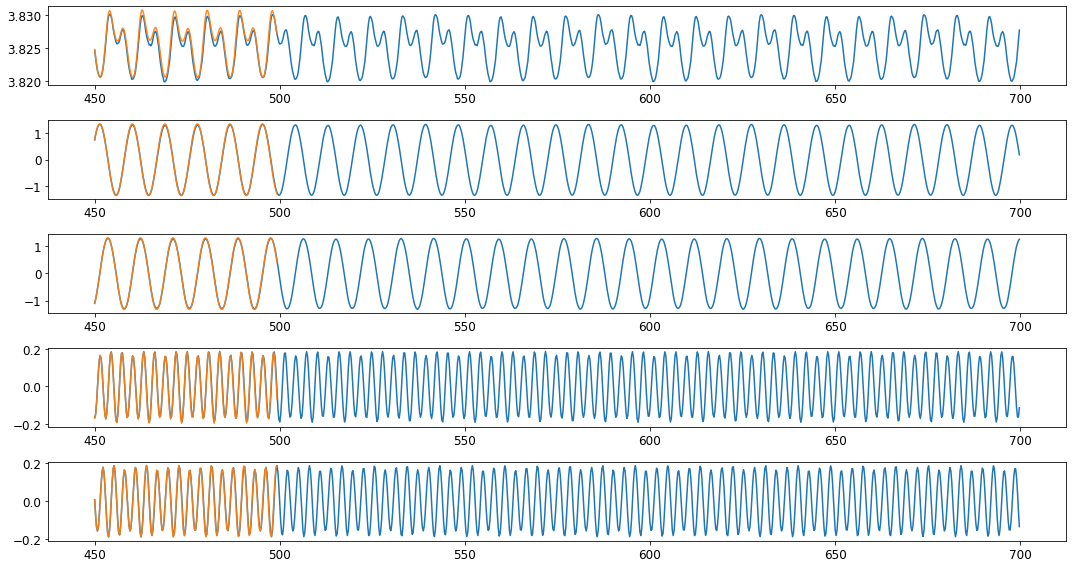

In [40]:
fig, ax = plt.subplots(5,1, figsize=[15,8])
for i in range(5):      
    ax.flatten()[i].plot(times_pred[n:n+npredict], time_level_pred[:,i])
    ax.flatten()[i].plot(times[n:-1], reframed.values[n:, i], alpha=0.9)
    
plt.tight_layout()
#plt.savefig('GAN_0-end_p4.png')